In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# Downloading data from Yahoo
r'''
import yahoofinance as yf
symbol ='DTE.DE'
hist = yf.HistoricalPrices(symbol,  '2014-10-31', '2020-11-11', frequency='1d')
hist.to_csv(r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\DAX/' + symbol + '.csv')
'''

"\nimport yahoofinance as yf\nsymbol ='DTE.DE'\nhist = yf.HistoricalPrices(symbol,  '2014-10-31', '2020-11-11', frequency='1d')\nhist.to_csv(r'C:\\Users\\MMD\\PycharmProjects\\Trading\\Data Mining\\Data\\DAX/' + symbol + '.csv')\n"

In [3]:
import datetime
import glob
import webbrowser
import os.path
import pandas as pd
import backtrader as bt
import backtrader.analyzers as btanal
import pyfolio as pf
import numpy as np
import sys
from scipy.stats import linregress
import quantstats as qs
import seaborn as sns
import optunity.metrics

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,13)

import warnings 
warnings.simplefilter(action='ignore', category=Warning)
warnings.simplefilter(action='ignore', category=FutureWarning)

globalparams = dict(cash=10000,            
                    commission=0.005,
                    reserve=0.06,
                    strategy="St", #HSt = Buy and Hold, St = Standard Strategy for non-survivorship free bias momentum
                    heatmap=False,
                    optunity=False,
                    )

c:\users\mmd\appdata\local\programs\python\python36\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
c:\users\mmd\appdata\local\programs\python\python36\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [4]:
import backtrader as bt
# <<<Function section>>>

# Momentum Function thanks to Teddy Koker https://teddykoker.com/2019/05/momentum-strategy-from-stocks-on-the-move-in-python/
def momentum_func(self, the_array):
    r = np.log(the_array)
    slope, _, rvalue, _, _ = linregress(np.arange(len(r)), r)
    annualized = (1 + slope) ** 252
    return annualized * (rvalue ** 2)

def momentum_func1(self, the_array):
    r = np.log(the_array)
    slope, _, rvalue, _, _ = linregress(np.arange(len(r)), r)
    annualized = (1 + slope) ** 252
    return annualized

class Momentum(bt.ind.OperationN):
    lines = ('trend',)
    func = momentum_func1

# Great Heatmap to analyse Output of opstrategy
def my_heatmap(data):
    data = np.array(data)
    xs = np.unique(data[:, 1].astype(int))
    ys = np.unique(data[:, 0].astype(float))
    vals = data[:, 3].reshape(len(ys), len(xs))
    min_val_ndx = np.unravel_index(np.argmin(vals, axis=None), vals.shape)
    max_val_ndx = np.unravel_index(np.argmax(vals, axis=None), vals.shape)

    cmap = LinearSegmentedColormap.from_list('', ['red', 'orange', 'yellow', 'chartreuse', 'limegreen'])
    ax = sns.heatmap(vals, xticklabels=xs, yticklabels=ys, cmap='viridis', annot=True, fmt='.2f')

    ax.add_patch(Rectangle(min_val_ndx[::-1], 1, 1, fill=False, edgecolor='blue', lw=3, clip_on=False))
    ax.add_patch(Rectangle(max_val_ndx[::-1], 1, 1, fill=False, edgecolor='blue', lw=3, clip_on=False))

    plt.tight_layout()
    plt.show()

class CashMarket(bt.analyzers.Analyzer):
    """
    Analyzer returning cash and market values
    Thanks to run-out https://community.backtrader.com/post/11669
    """
    def create_analysis(self):
        self.rets = {}
        self.vals = 0.0

    def notify_cashvalue(self, cash, value):
        self.vals = (cash, value)
        self.rets[self.strategy.datetime.datetime().strftime("%Y-%m-%d")] = self.vals

    def get_analysis(self):
        return self.rets

In [5]:
# <<<Benchmark Strategy section>>>  
# Non-survivorship bias Benchmark Strategy
class HSt(bt.Strategy):
    """
    HoldAll Strategy.
    Usually, used for benchmarking test.
    Almost same with the HoldStrategy, it tries to buy all provided securities with the same ratio.
    buy_date: iso-format str, buy order will be created the first market day after the buy_date.
    https://github.com/samuel281/qu-ant/blob/master/lib/strategies/hold_all_strategy.py
    """
    params = dict(
        buy_date=datetime.datetime.today().isoformat(),
    )
    
    def __init__(self):
        self.stocks = self.datas[2:] #must filter out bond and spy 
                  
    def next(self):
        for d in self.stocks:
            if self.getposition(data=d).size:
                return
        
        if self.data.datetime.date(0).isoformat() < self.params.buy_date.isoformat(): #buydate must be determined by the first strategy, since it is the date of the first trade?
            return

        target_ratio = 1.0 - globalparams["reserve"]
        target_ratio_per_sec = target_ratio / len(self.stocks)            
        for d in self.stocks:
            self.order_target_percent(data=d, target=target_ratio_per_sec)            
    
    def log(self, arg):
        print('{} {}'.format(self.datetime.date(), arg))            
            
    def on_order_executed(self, order):
        pass
    
    
    def notify_order(self, order):
        if order.status in [order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        if order.status in [order.Submitted]:
            if order.isbuy():

                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} {} Price {:.2f} Value {:.2f} Size {} Cash {:.2f} Broker {:.2f}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price , order.created.size, self.broker.getcash(), self.broker.getvalue()))
            if order.issell():
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} {} Price {:.2f} Value {:.2f} Size {} Broker {:.2f}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price, order.created.size, self.broker.getvalue()))

            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))

            if order.issell():# Sell
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
       

In [6]:
class Sur(bt.Strategy):
    params = dict(
            selcperc=0.10,  # percentage of stocks to select from the universe
            rperiod=1,  # period for the returns calculation, default 1 period
            vperiod=55,  # lookback period for volatility - default 36 periods
            mperiod=155,  # lookback period for momentum - default 90 periods
            momentum=Momentum, # parametrize the momentum and its period
            reserve=globalparams["reserve"],  # 5% reserve capital
            monthdays=[1],
            monthcarry=True,
            when=bt.timer.SESSION_START,
            benchmarkstop=False, # If true, no stocks will be bought and no rebalancing will be done if benchmark is below SMAperiod
            SMAperiod=200,
            benchmark_bond=True, # Sell all Stocks and buy Bonds
            jump_momentum=True, # If true, after a time of jump_one (30 days x jump_one) in every month, all the money will be directed to the best performing stock. Rule for that:
                                # In Excel, this is a 0.6 x month return of fund with best past 3 month return plus 0.4 x return of fund with best return, month to date.
            jump_one=0.6,
            printlog=True,
        )

    def __init__(self):
        self.bench = self.data0
        self.bond = self.data1
        self.stocks = self.datas[2:]
        # calculate 1st the amount of stocks that will be selected
        self.selnum = int(len(self.stocks) * self.p.selcperc)

        # allocation perc per stock
        # reserve kept to make sure orders are not rejected due to
        # margin. Prices are calculated when known (close), but orders can only
        # be executed next day (opening price). Price can gap upwards
        self.perctarget = (1.0 - self.p.reserve) / self.selnum
        
        # This is the set up of the timer that makes the strategy being executed at the given time
        self.add_timer(
            when=self.p.when,
            monthdays=self.p.monthdays,
            monthcarry=self.p.monthcarry
        )
        
        self.stocks_len = []
        
        jump = True

        # returns, volatilities and momentums
        rs = [bt.ind.PctChange(d, period=self.p.rperiod) for d in self.stocks]
        vs = [bt.ind.StdDev(ret, period=self.p.vperiod) for ret in rs]
        #ms = [bt.ind.ROC(d, period=self.p.mperiod) for d in self.datas]
        ms = [self.p.momentum(d, period=self.p.mperiod) for d in self.stocks]
        
        self.bench_sma = bt.ind.SMA(self.data0, period=self.p.SMAperiod)
        
        # simple rank formula: (momentum * net payout) / volatility
        # the highest ranked: low vol, large momentum, large payout
        self.ranks = {d: m / v for d, v, m in zip(self.stocks, vs, ms)}
        #TODO: does it perform better without the volatility?

        self.bench_filter = self.bench < self.bench_sma


    def log(self, arg):
        if self.p.printlog:
            print('{} {}'.format(self.datetime.date(), arg))
        
    # This section is for logging of orders in greater detail to figure out whether the strategy is actually having no problem with orders
    '''
    def notify_order(self, order):
        if order.status in [order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        if order.status in [order.Submitted]:
            if order.isbuy():
            
                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} {} Price {:.2f} Value {:.2f} Size {} Cash {:.2f}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price , order.created.size, self.broker.getcash()))
            if order.issell():
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price, order.created.size))

            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))

            if order.issell():# Sell
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))


        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
    '''       
    
    # This is the function using the timer to execute the rebalance 
    def notify_timer(self, timer, when, *args, **kwargs):
        print('strategy notify_timer with tid {}, when {} _getminperstatus {}'.
              format(timer.p.tid, when, int(self._getminperstatus())))
        print("timer")
        if self._getminperstatus() < 0:
            self.rebalance()
    
    def nextstart(self):
        self.ranks_filter = self.ranks
        print("nextstart")
        self.next()
        
    def prenext(self):
        self.stocks_len = [d for d in self.stocks if len(d)]
        self.ranks_filter = dict(zip(self.stocks_len, [self.ranks[k] for k in self.stocks_len]))        
        self.next()
        
    def next(self):
        print("next")
        pass # must be filled with a pass

    
    # Actual order giving by a ranking takes place here
    def rebalance(self):
        print("rebalance")
        #if jump == True:
        # Enter Jump Code here    
        
        # sort data and current rank
        ranks = sorted(
            self.ranks_filter.items(),  # get the (d, rank), pair
            key=lambda x: x[1][0],  # use rank (elem 1) and current time "0"
            reverse=True,  # highest ranked 1st ... please
        )
        
        # put top ranked in dict with data as key to test for presence
        rtop = dict(ranks[:self.selnum])

        # For logging purposes of stocks leaving the portfolio
        rbot = dict(ranks[self.selnum:])

        # prepare quick lookup list of stocks currently holding a position
        posdata = [d for d, pos in self.getpositions().items() if pos]
        

        if self.p.benchmarkstop:
            for d in (d for d in posdata):
                if "Bond" == d._name and self.bench_filter:
                    return
                else:
                    if "Bond" == d._name and not self.bench_filter:
                        self.order_target_percent("Bond", target=0.0)
                        self.log('Leave {} due to end of down period'.format(d._name))
                        return
        
        # Triple Momentum: If Benchmark index is below SMA, nothing will be bought or rebalanced
        if self.p.benchmarkstop:
            if self.bench_filter:
                #print('SMA {} - Bench {}'.format(self.bench_sma[0], self.bench[0]))
                if self.p.benchmark_bond:
                    for d in posdata:
                        self.log('Leave {} due to switch to Bonds'.format(d._name))
                        self.order_target_percent(d, target=0.0)
                    self.order_target_percent("Bond", target=0.95)
                    self.log('Buy Bond')
                    bond_flag = True
                    return #Code stops here and skips rebalancing und buying

        # remove those no longer top ranked
        # do this first to issue sell orders and free cash
        for d in (d for d in posdata if d not in rtop):
            self.log('Leave {} - Rank {:.2f}'.format(d._name, rbot[d][0]))
            self.order_target_percent(d, target=0.0)
        
        # rebalance those already top ranked and still there
        for d in (d for d in posdata if d in rtop):
            self.log('Rebal {} - Rank {:.2f}'.format(d._name, rtop[d][0]))
            self.order_target_percent(d, target=self.perctarget)
            del rtop[d]  # remove it, to simplify next iteration

        # issue a target order for the newly top ranked stocks
        # do this last, as this will generate buy orders consuming cash
        for d in rtop:
            self.log('Enter {} - Rank {:.2f}'.format(d._name, rtop[d][0]))
            self.order_target_percent(d, target=self.perctarget)
            
    def stop(self):
        pnl = round(self.broker.getvalue() - globalparams["cash"],2)
        print('Final PnL: {}'.format(
            pnl))

0 2
0.475 perc_sizer
2015-12-04 Enter ARKW - Rank 1.33
2015-12-04 Enter ARKK - Rank 1.15
Buy Submitted 2015-12-04 ARKW Price 19.00 Value 4731.89 Size 249 Cash 475.07
Buy Submitted 2015-12-04 ARKK Price 19.37 Value 4745.65 Size 245 Cash 475.07
Buy 2015-12-04 ARKW Price 19.00 Value 4731.89 Size 249
Buy 2015-12-04 ARKK Price 19.37 Value 4745.65 Size 245
2015-12-04 Leave ARKK - Rank 1.15
5033.299943999999 1
0.47077271185149344 perc_sizer
2015-12-04 Enter QQQ - Rank 1.15
Sell Submitted 2015-12-04 ARKK Price 20.39 Value -4994.58 Size -245
Buy Submitted 2015-12-04 QQQ Price 108.78 Value 4894.92 Size 45 Cash 525.28
Sell 2015-12-04 ARKK Price 20.39 Value 4745.65 Size -245
Buy 2015-12-04 QQQ Price 108.78 Value 4894.92 Size 45
2016-07-29 Leave ARKW - Rank 1.00
4494.058784999999 1
0.48200838104924626 perc_sizer
2016-07-29 Enter EUNL.DE - Rank 1.14
Sell Submitted 2016-08-02 ARKW Price 18.41 Value -4583.52 Size -249
Buy Submitted 2016-08-02 EUNL.DE Price 38.52 Value 4622.40 Size 120 Cash 440.37
Sell

<IPython.core.display.Javascript object>


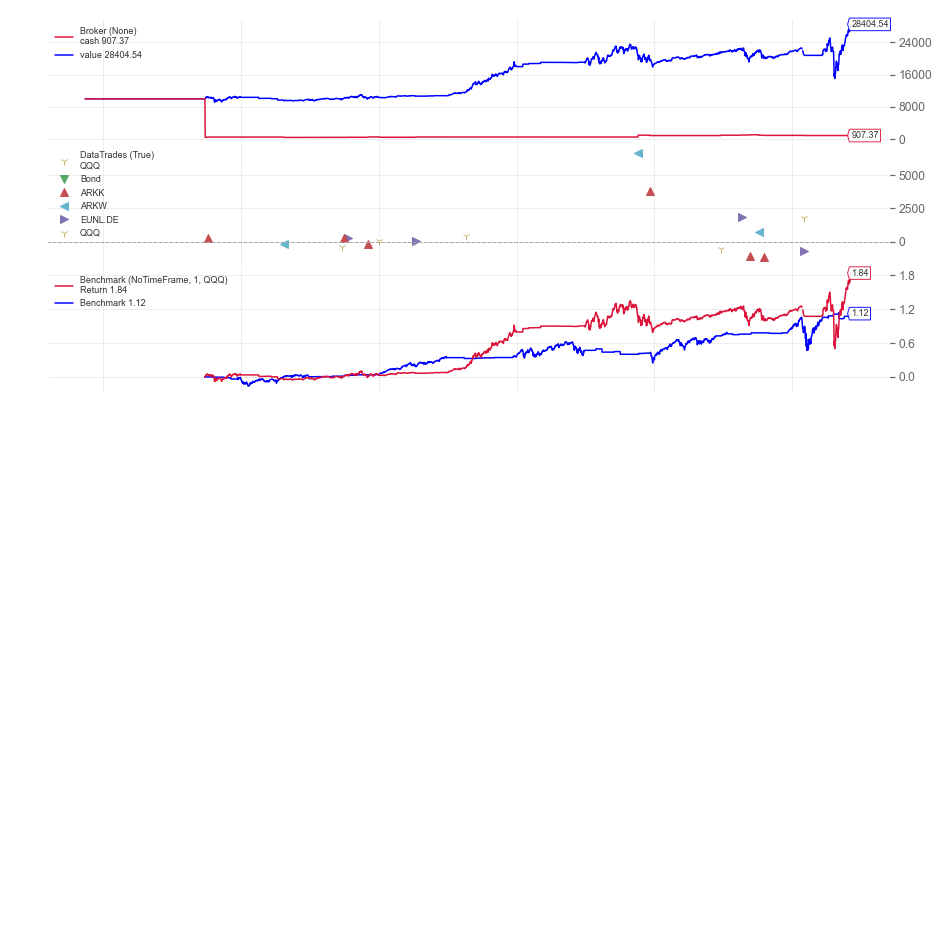

Profit ... or Loss: 18404.54


<IPython.core.display.Javascript object>


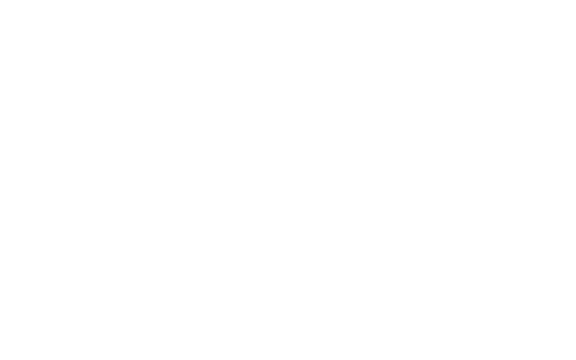

<IPython.core.display.Javascript object>


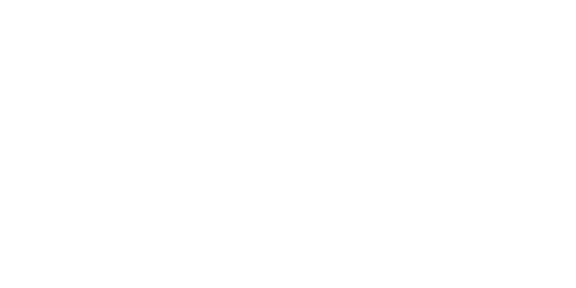

<IPython.core.display.Javascript object>


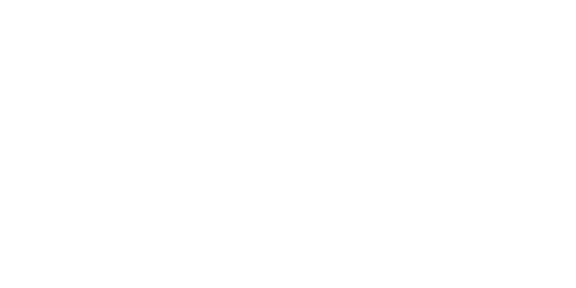

<IPython.core.display.Javascript object>


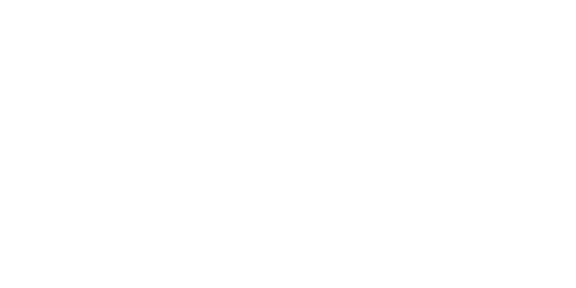

<IPython.core.display.Javascript object>


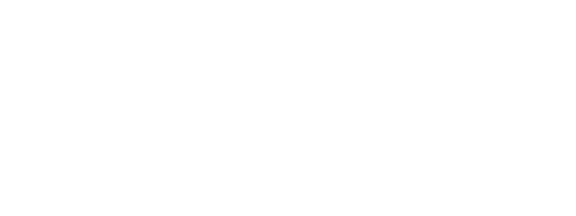

<IPython.core.display.Javascript object>


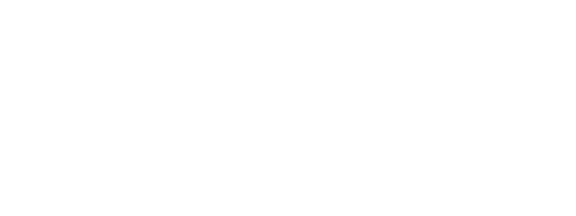

<IPython.core.display.Javascript object>


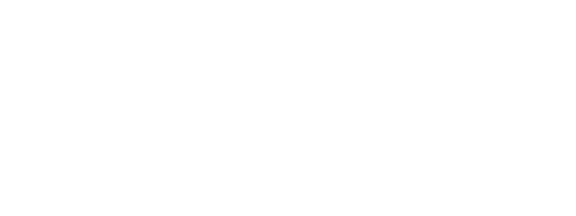

<IPython.core.display.Javascript object>


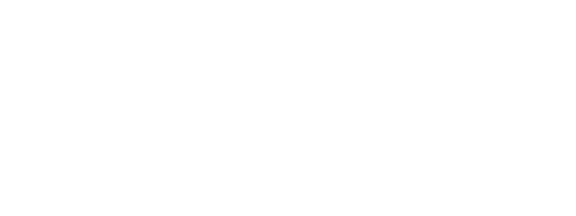

<IPython.core.display.Javascript object>


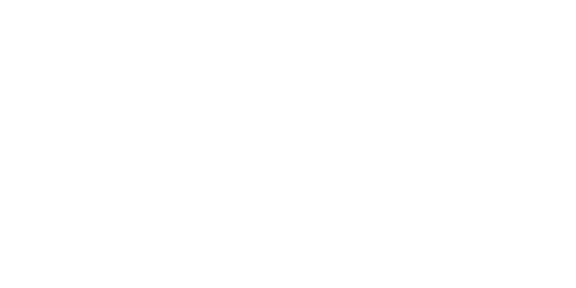

<IPython.core.display.Javascript object>


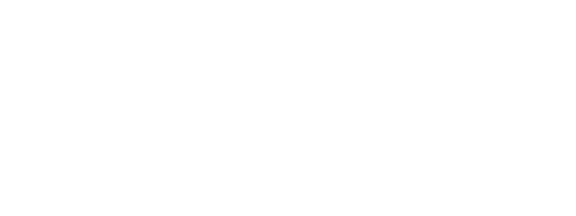

<IPython.core.display.Javascript object>


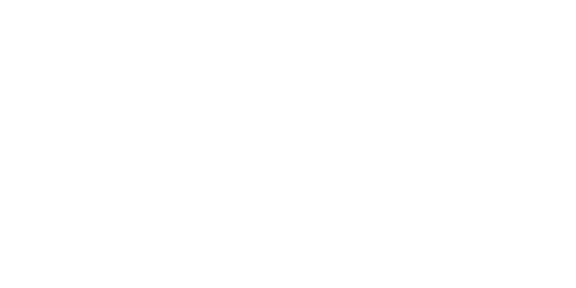

<IPython.core.display.Javascript object>


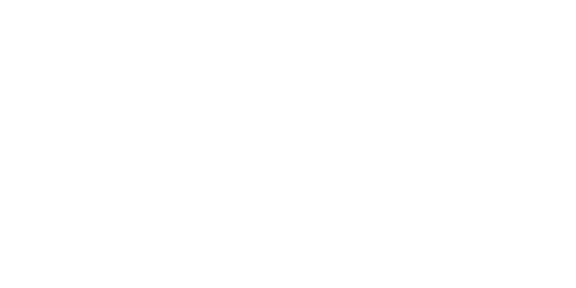

In [23]:
# <<<Momentum Strategy section>>>
class St(bt.Strategy):
    params = dict(
        selcperc=0.5,  # percentage of stocks to select from the universe
        rperiod=1,  # period for the returns calculation, default 1 period
        vperiod=45,  # lookback period for volatility - default 36 periods
        mperiod=155,  # lookback period for momentum - default 90 periods
        momentum=Momentum, # parametrize the momentum and its period
        reserve=globalparams["reserve"],  # 5% reserve capital
        monthdays=[1],
        monthcarry=True,
        weekdays=[5],
        weekcarry=True,
        weeks_between=1,
        when=bt.timer.SESSION_START,
        benchmarkstop=False, # If true, no stocks will be bought and no rebalancing will be done if benchmark is below SMAperiod
        SMAperiod=100,
        benchmark_bond=True, # Sell all Stocks and buy Bonds
        jump_momentum=True, # If true, after a time of jump_one (30 days x jump_one) in every month, all the money will be directed to the best performing stock. Rule for that:
                            # In Excel, this is a 0.6 x month return of fund with best past 3 month return plus 0.4 x return of fund with best return, month to date.
        jump_one=0.6,
        printlog=True,
    )

    def __init__(self):
        self.bench = self.data0
        self.bond = self.data1
        self.stocks = self.datas[2:]
        # calculate 1st the amount of stocks that will be selected
        self.selnum = int(len(self.stocks) * self.p.selcperc)

        # allocation perc per stock
        # reserve kept to make sure orders are not rejected due to
        # margin. Prices are calculated when known (close), but orders can only
        # be executed next day (opening price). Price can gap upwards
        self.perctarget = (1.0 - self.p.reserve) / self.selnum
        self.timer_i = 0
        # This is the set up of the timer that makes the strategy being executed at the given time
        self.add_timer(
            when=self.p.when,
            #weekdays=self.p.weekdays,
            #weekcarry=self.p.weekcarry
            monthdays=self.p.monthdays,
            monthcarry=self.p.monthcarry
        )
        
        jump = True

        # returns, volatilities and momentums
        rs = [bt.ind.PctChange(d, period=self.p.rperiod) for d in self.stocks]
        vs = [bt.ind.StdDev(ret, period=self.p.vperiod) for ret in rs]
        #ms = [bt.ind.ROC(d, period=self.p.mperiod) for d in self.datas]
        ms = [self.p.momentum(d, period=self.p.mperiod) for d in self.stocks]
        
        self.bench_sma = bt.ind.SMA(self.data0, period=self.p.SMAperiod)
        
        # simple rank formula: (momentum * net payout) / volatility
        # the highest ranked: low vol, large momentum, large payout
        self.ranks = {d: m for d, v, m in zip(self.stocks, vs, ms)}
        #TODO: does it perform better without the volatility?

        self.bench_filter = self.bench < self.bench_sma


    def log(self, arg):
        if self.p.printlog:
            print('{} {}'.format(self.datetime.date(), arg))
        
    # This section is for logging of orders in greater detail to figure out whether the strategy is actually having no problem with orders
    
    def notify_order(self, order):
        if order.status in [order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        if order.status in [order.Submitted]:
            if order.isbuy():
            
                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} {} Price {:.2f} Value {:.2f} Size {} Cash {:.2f}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price , order.created.size, self.broker.getcash()))
            if order.issell():
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price, order.created.size))

            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))

            if order.issell():# Sell
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))


        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
           
    
    # This is the function using the timer to execute the rebalance 
    def notify_timer(self, timer, when, *args, **kwargs):
        #print('strategy notify_timer with tid {}, when {} _getminperstatus {}'.
        #      format(timer.p.tid, when, int(self._getminperstatus())))
        if self._getminperstatus() < 0:
            self.timer_i += 1
            if self.timer_i == self.p.weeks_between:
                self.timer_i = 0
                self.rebalance()
  
    def next(self):
        pass # must be filled with a pass

    
    # Actual order giving by a ranking takes place here
    def rebalance(self):
        
        #if jump == True:
        # Enter Jump Code here    
        
        # sort data and current rank
        ranks = sorted(
            self.ranks.items(),  # get the (d, rank), pair
            key=lambda x: x[1][0],  # use rank (elem 1) and current time "0"
            reverse=True,  # highest ranked 1st ... please
        )
        
        # put top ranked in dict with data as key to test for presence
        rtop = dict(ranks[:self.selnum])

        # For logging purposes of stocks leaving the portfolio
        rbot = dict(ranks[self.selnum:])

        # prepare quick lookup list of stocks currently holding a position
        posdata = [d for d, pos in self.getpositions().items() if pos]
        

        if self.p.benchmarkstop:
            for d in (d for d in posdata):
                if "Bond" == d._name and self.bench_filter:
                    return
                else:
                    if "Bond" == d._name and not self.bench_filter:
                        self.order_target_percent("Bond", target=0.0)
                        self.log('Leave {} due to end of down period'.format(d._name))
                        return
        
        # Triple Momentum: If Benchmark index is below SMA, nothing will be bought or rebalanced
        if self.p.benchmarkstop:
            if self.bench_filter:
                #print('SMA {} - Bench {}'.format(self.bench_sma[0], self.bench[0]))
                if self.p.benchmark_bond:
                    for d in posdata:
                        self.log('Leave {} due to switch to Bonds'.format(d._name))
                        self.order_target_percent(d, target=0.0)
                    self.order_target_percent("Bond", target=0.95)
                    self.log('Buy Bond')
                    bond_flag = True
                return #Code stops here and skips rebalancing und buying

        # remove those no longer top ranked
        # do this first to issue sell orders and free cash
        for d in (d for d in posdata if d not in rtop):
            self.log('Leave {} - Rank {:.2f}'.format(d._name, rbot[d][0]))
            self.order_target_percent(d, target=0.0)
        
        sum_stocks = 0
        # rebalance those already top ranked and still there
        for d in (d for d in posdata if d in rtop):
            #self.log('Rebal {} - Rank {:.2f}'.format(d._name, rtop[d][0]))
            #self.order_target_percent(d, target=self.perctarget)
            #Rebalances are just pricy no brainer operations which are needed for the buying part ... since it is based on equal weights...
            del rtop[d]  # remove it, to simplify next iteration
            sum_stocks += self.broker.getposition(d).size * self.broker.getposition(d).adjbase
        
        
        
        if len(rtop):
            print(sum_stocks, len(rtop))
            sizer_perc = (0.95 - sum_stocks / self.broker.get_value()) / len(rtop)
            print(sizer_perc, "perc_sizer")
            sum_stocks = 0
        
        # issue a target order for the newly top ranked stocks
        # do this last, as this will generate buy orders consuming cash
        for d in rtop:
            self.log('Enter {} - Rank {:.2f}'.format(d._name, rtop[d][0]))
            #self.order_target_percent(d, target=self.perctarget)
            self.order_target_percent(d, target=sizer_perc)
            
    def stop(self):
        pnl = round(self.broker.getvalue() - globalparams["cash"],2)
        print('Final PnL: {}'.format(
            pnl))
    

def run(args=None):
    #optreturn=False otherwise the heatmap doesn't work
    cerebro = bt.Cerebro(maxcpus=1,
                         preload=False,
		                 optdatas=False,
		                 optreturn=False,
		                 stdstats=True) 

    
# <<<Data loading section>>>
    
    # Parse from/to-date
    fromdate = datetime.datetime(2014, 11, 3)
    todate = datetime.datetime(2020, 6, 18)
    
    # Add SPY/QQQ as "Benchmark"
    df0 = pd.read_csv(r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\QQQ.csv', index_col=0, parse_dates=True)
    benchdata = bt.feeds.PandasData(dataname=df0,name="QQQ",fromdate=fromdate, todate=todate,  plot=False)
    cerebro.adddata(benchdata)

    # Add TMF as "Bond"
    df1 = pd.read_csv(r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\TMF.csv', index_col=0, parse_dates=True)
    bonddata = bt.feeds.PandasData(dataname=df1,name="Bond",fromdate=fromdate, todate=todate, plot=False)
    cerebro.adddata(bonddata)    
    
    # add all the data files available in the directory datadir
    for fname in glob.glob(os.path.join(r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\Momentum', '*')):
        df = pd.read_csv(fname, index_col=0, parse_dates=True)

        if len(df)>200:
            cerebro.adddata(bt.feeds.PandasData(dataname=df,name=os.path.basename(fname).replace(".csv", ""),fromdate=fromdate, todate=todate, plot=False))
            #print(os.path.basename(fname).replace(".csv", "")) #prints the name of the added csv file
            
            
# <<<Cerebro loading section>>>


    # Optimization by Optunity (usually partical swarm if i remember correctly)
    def runstrat(p1, p2):
        cerebro = bt.Cerebro(maxcpus=0,stdstats=True)
        cerebro.addstrategy(St, selcperc=p1, mperiod=int(p2),printlog=False) #change the parameters that should be depicted in heatmap
        cerebro.broker.setcash(globalparams["cash"])
        cerebro.broker.setcommission(commission=globalparams["commission"])
        cerebro.adddata(benchdata)
        cerebro.adddata(bonddata)  
        for fname in glob.glob(os.path.join(r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\DAX', '*')):
            df = pd.read_csv(fname, index_col=0, parse_dates=True)
            if len(df)>200:
                cerebro.adddata(bt.feeds.PandasData(dataname=df,name=os.path.basename(fname).replace(".csv", ""),fromdate=fromdate, todate=todate, plot=False))        
        
        cerebro.broker.set_coc(True)
        cerebro.run(maxcpus=0)
        return cerebro.broker.getvalue() #can be switched to whatever should be maximized/minimized
   
    #Either use Optunity for quick search of optimum
    if globalparams["optunity"]:
        opt = optunity.maximize(runstrat, num_evals=200, p1 = [1, 300], p2=[2, 100])

        optimal_pars, details, _ = opt
        print('Optimal Parameters:')
        print('maperiod1 = %.4f' % optimal_pars['p1'])
        print('maperiod2 = %.4f' % optimal_pars['p2'])
    
    
    # Heatmap showing how variables i = (y axis/ p1) and j = (x axis /p2) impact strategy outcome
    if globalparams["heatmap"]:
        results_list = []
        for i in np.arange(0.042, 0.75, 0.042):
            for j in np.arange(30, 200, 10):
                PnL = runstrat(p1=i, p2=j)
                results_list.append([i, j, i,PnL])
        my_heatmap(results_list)
    
    
    # add strategy
    if globalparams["optunity"]:
        cerebro.addstrategy(eval(globalparams["strategy"]), mperiod=int(optimal_pars['p1']), vperiod=int(optimal_pars['p2']))
    elif globalparams["strategy"] == "HSt":
        cerebro.addstrategy(HSt, buy_date=datetime.date(2015, 8, 31))
    else:    
        cerebro.addstrategy(eval(globalparams["strategy"]))
        
    
    # set the cash, cheat on close and commission
    cerebro.broker.setcash(globalparams["cash"])
    cerebro.broker.set_coc(True)
    cerebro.broker.setcommission(commission=globalparams["commission"])
    
    # Adding Analysers
    #cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0, _name='sharpe')

    cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annual_return')
    cerebro.addanalyzer(CashMarket, _name='cashmarket')
    
    cerebro.addanalyzer(btanal.PyFolio)                # Needed to use PyFolio & Quanstat
    cerebro.addanalyzer(btanal.TradeAnalyzer)          # Analyzes individual trades
    
    
    
    # If you want to have all data written into a log file
    #cerebro.addwriter(bt.WriterFile, csv=True, out='log.csv')
    
    cerebro.addobserver(bt.observers.Benchmark,
                        data=benchdata,
                        timeframe=bt.TimeFrame.NoTimeFrame)

    results = cerebro.run(maxcpus=1)#maxcpu=1 otherwise pickling multiprocessing errors
    
# <<<Performance analysing section section>>>

    cerebro.plot()

    # Basic performance evaluation ... final value ... minus starting cash
    pnl = cerebro.broker.get_value() - globalparams["cash"]
    print('Profit ... or Loss: {:.2f}'.format(pnl))

    # Quantstats thanks to https://algotrading101.com/learn/backtrader-for-backtesting/
    # Does not work with optstrategy
    
    returns, positions, transactions, gross_lev = results[0].analyzers.pyfolio.get_pf_items()
    returns.index = returns.index.tz_convert(None)
    qs.reports.html(returns, output='stats.html', title='Momentum '+ globalparams["strategy"])
    webbrowser.open('stats.html')

    
    # Pyfolio if needed
    '''
    returns, positions, transactions, gross_lev = results[0].analyzers.pyfolio.get_pf_items()
    benchmark_rets = pd.Series([0.00004] * len(returns.index), index=returns.index)     
    pf.create_full_tear_sheet(returns, positions, transactions, benchmark_rets=benchmark_rets)
    '''
    
# <<<Execute starting section>>>    
if __name__ == '__main__':
    run()

In [8]:
# how do the single stocks perform over the time frame
r'''
fdate = datetime.datetime(2015, 8, 31)
tdate = datetime.datetime(2020, 6, 18)
for fname in glob.glob(os.path.join(r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\Momentum Stocks', '*')):
    df = pd.read_csv(fname, index_col=0, parse_dates=True)
    a = df.at[fdate,"Close"]
    b = df.at[tdate,"Close"]
    print(b/a)
'''

'\nfdate = datetime.datetime(2015, 8, 31)\ntdate = datetime.datetime(2020, 6, 18)\nfor fname in glob.glob(os.path.join(r\'C:\\Users\\MMD\\PycharmProjects\\Trading\\Data Mining\\Data\\Momentum Stocks\', \'*\')):\n    df = pd.read_csv(fname, index_col=0, parse_dates=True)\n    a = df.at[fdate,"Close"]\n    b = df.at[tdate,"Close"]\n    print(b/a)\n'